In [3]:
# run this cell to ensure course package is installed
import sys
from pathlib import Path

course_tools_path = Path('../Course_Tools/').resolve() # change this to the local path of the course package
sys.path.append(str(course_tools_path))

from install_introdl import ensure_introdl_installed
ensure_introdl_installed(force_update=False, local_path_pkg= course_tools_path / 'introdl')

The `introdl` module is already installed.


In [4]:
from sklearn.model_selection import train_test_split
from pathlib import Path

import torch
import torch.optim as optim
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
import torchvision.transforms.v2 as T
from torch.utils.data import Dataset, DataLoader
from torchvision import tv_tensors

from graphics_and_data_prep import display_images_and_boxes, train_rcnn, mAP_widget

from introdl.visul import plot_training_metrics
from introdl.utils import config_paths_keys, load_results, load_model

paths = config_paths_keys()
MODELS_PATH = paths['MODELS_PATH']
DATA_PATH = paths['DATA_PATH']

MODELS_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models
DATA_PATH=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\data
TORCH_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads
HF_HOME=C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\downloads


# Object Detection

In this notebook we'll fine-tune a Faster R-CNN model to detect pedestrian in the [Penn-Fudan dataset](https://www.cis.upenn.edu/~jshi/ped_html/).  It consists of 170 images with 345 labeled pedestrians taken on two university campuses.  You should have read the textbook to get an idea of how the Faster R-CNN model works so we'll focus here on two main things.  First, we'll look at the Mean Average Precision (mAP) metric for evaluating how well an objective detection model both identifies and localizes objects.  Second, we'll examine how we can filter out redundant and low-confidence predicted boxes.

## Evaluating an Object Detection Model - mean Average Precision (mAP)

In object detection, **Mean Average Precision (mAP)** is a key metric for evaluating how well a model identifies and localizes multiple object types within an image. Here are the core concepts:

### Key Concepts of mAP for Object Detection

1. **Intersection over Union (IoU)**:
   - **IoU** measures the overlap between a predicted bounding box and the ground truth bounding box (similar to segmentation masks). It is calculated as:
     $$\text{IoU} = \frac{\text{Area of Overlap}}{\text{Area of Union}}$$
   - IoU values range from 0 to 1, where values closer to 1 indicate a high overlap, meaning the prediction closely matches the ground truth. IoU thresholds, often 0.5 and 0.75, determine the minimum overlap required for a correct detection.

2. **True Positives (TP), False Positives (FP), and False Negatives (FN)**:
   - A **True Positive** occurs when a predicted bounding box matches a ground truth box with IoU above the threshold.
   - A **False Positive** occurs when a predicted box does not match any ground truth box (IoU below threshold) or detects a non-existent object.
   - A **False Negative** occurs when a ground truth box has no matching predicted box, indicating the model missed detecting an actual object.
   - We don't condider **True Negatives** in object detection because we are only interested in detecting objects, not the absence of objects.

3. **Precision and Recall**:
   - **Precision** measures how many of the detected objects are correct, calculated as:
     $$\text{Precision} = \frac{\text{TP}}{\text{TP + FP}}$$
   - **Recall** measures how many actual objects the model detected, calculated as:
     $$\text{Recall} = \frac{\text{TP}}{\text{TP + FN}}$$
   - Precision and Recall are typically calculated at multiple IoU thresholds (e.g., 0.5, 0.75) to reflect different levels of localization accuracy.

4. **Precision-Recall Curve and Average Precision (AP)**:
   - For each IoU threshold, a **Precision-Recall curve** is plotted by varying the confidence threshold of detections.
   - The **Average Precision (AP)** at each IoU threshold is the area under the Precision-Recall curve, providing a measure of the model’s accuracy at that IoU level.

5. **Mean Average Precision (mAP)**:
   - **mAP** is the mean of AP values across multiple IoU thresholds and classes.
   - In multi-class detection, mAP averages AP across both classes and IoU thresholds, providing a single score representing the model’s overall detection and localization performance across object types.

Watch the video below and play with the widget to get a better idea of how mAP works.

INSERT VIDEO HERE.

In [5]:
# execute this cell to see the demonstration widget
mAP_widget()

## Preparing the data

We'll use a custom dataset that inherits from torch.utils.data.Dataset.  The construction is similar to that of the custom dataset we made in the segmenation notebook earlier in this lesson.  Rather than read the bounding boxes from the annotations supplied with the PennFudan dataset, we use the segmenation masks to construct the bounding boxes.  Becaause the dataset is so small we want to use agressive data augmentation to reduce overfitting.  Our augmentation will include rotations and translations.  To get the most accurate boxes we apply the transforms to the masks and then recompute the boxes.  

Below is short video discussing this custom class.

INSERT VIDEO HERE.

In [6]:
class PennFudanDetect(Dataset):
    """
    A custom dataset class for the Penn-Fudan Database for Pedestrian Detection and Segmentation.
    
    Args:
        root (str or Path): Root directory of the dataset.
        transforms (callable, optional): A function/transform that takes in an image and target and returns a transformed version.
        split (str, optional): The dataset split, either 'train' or 'val'. Default is 'train'.
        test_size (float, optional): Proportion of the data to be used for validation. Default is 0.2.
        seed (int, optional): Random seed for reproducibility. Default is 42.
    """
    def __init__(self, root, transforms=None, split='train', test_size=0.2, seed=42):
        self.root = Path(root)
        self.transforms = transforms

        # Load all image and mask filepaths
        self.all_imgs = sorted((self.root / "PNGImages").iterdir())
        self.all_masks = sorted((self.root / "PedMasks").iterdir())

        # Ensure that the number of images and masks are the same
        assert len(self.all_imgs) == len(self.all_masks), "The number of images and masks must be the same"

        # Split dataset into train and validation
        indices = list(range(len(self.all_imgs)))
        train_indices, val_indices = train_test_split(indices, test_size=test_size, random_state=seed)

        if split == 'train':
            self.indices = train_indices
        elif split == 'val':
            self.indices = val_indices
        else:
            raise ValueError("Split must be 'train' or 'val'")

    def __getitem__(self, idx):
        # Map to the original index
        idx = self.indices[idx]

        # Load image and mask
        img = read_image(str(self.all_imgs[idx])).float() / 255.0
        mask = read_image(str(self.all_masks[idx]))

        # Convert image and mask to tv_tensors
        img = tv_tensors.Image(img)
        mask = tv_tensors.Mask(mask)

        # Create binary masks for each object (excluding background)
        obj_ids = torch.unique(mask)[1:]  # Exclude background (first ID)
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # Skip sample if there are no valid masks
        if masks.numel() == 0 or masks.sum() == 0:
            return None

        # Create a preliminary target with masks (boxes will be computed later)
        target = {"masks": tv_tensors.Mask(masks)}

        # Apply transformations (if any) to both image and masks
        if self.transforms is not None:
            img, target = self.transforms(img, target)
            masks = target["masks"]

        # Now compute bounding boxes from the transformed masks
        try:
            boxes = masks_to_boxes(masks)
        except RuntimeError as e:
            print(f"Skipping index {idx}: {e}")
            return None

        # Create labels (all objects are pedestrians)
        labels = torch.ones((len(boxes),), dtype=torch.int64)

        # Filter degenerate boxes (zero width or height)
        valid_indices = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        if not valid_indices.any():
            return None

        boxes = boxes[valid_indices]
        masks = masks[valid_indices]
        labels = labels[valid_indices]

        # Convert bounding boxes to tv_tensors with proper formatting
        boxes = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=img.shape[-2:])
        masks = tv_tensors.Mask(masks)

        # Update the target dictionary with computed boxes and labels
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks
        }

        return img, target

    def __len__(self):
        return len(self.indices)


## Data Augmentation and Loaders

We're using torchvisions.transforms.v2 because they can simultaneously tranform images, masks, and boxes.  We use RandomAffine to add rotation, translations, and rescaling (zooming in or out amd adding padding or cropping as needed). 

When you pass an image to a PyTorch R-CNN model, the model automatically:
1. **Resizes** the image to a predefined **min size** and **max size**.
2. **Normalizes** the image using ImageNet mean/std.
3. **Converts** it to a tensor.
4. **Performs inference** and returns outputs **scaled back to the original image size**.

This means our transforms do not need to include resizing or normalization.  We still convert to tensors in our transforms below because we want to transform the specialized `tv_tensors` to ordinary tensors after augmentation.

The custom collate_fn is applied by the dataloader to each batch.  It does two things:
1.  It converts the batch from the form ( (img1, target1), (img2, target2), ...) to ( (img1, img2, ...), (target1, target2, ...) ).
2.  Prevents any empty data from being loaded which could happen, for example, if a translated mask is empty.

In [ ]:
# Define training transformations
train_transforms = T.Compose([
    T.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(.8,1.2), shear=None),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToPureTensor(),
])

# Define validation transformations (no data augmentation, just tensor conversion and normalization)
val_transforms = T.Compose([
    T.ToPureTensor(),  # Convert to a standard torch.Tensor
])

# Usage with the dataset
dataset_path = DATA_PATH / "PennFudanPed"  # Update this path to your data
train_dataset = PennFudanDetect(root=dataset_path, split='train', transforms=train_transforms)
val_dataset = PennFudanDetect(root=dataset_path, split='val', transforms=val_transforms)

def collate_fn(batch):
    # Filter out None values
    batch = [b for b in batch if b is not None]
    return tuple(zip(*batch))  # Unpack into images and targets

# define training and validation data loaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

To illustrate some of the augmented images and their bounding boxes:

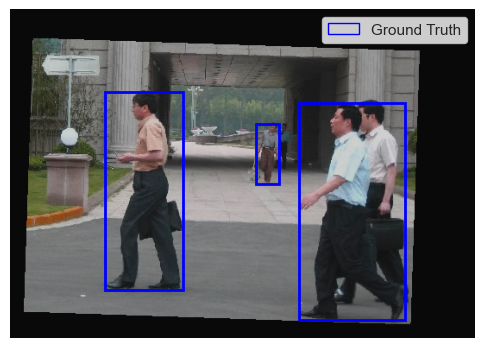

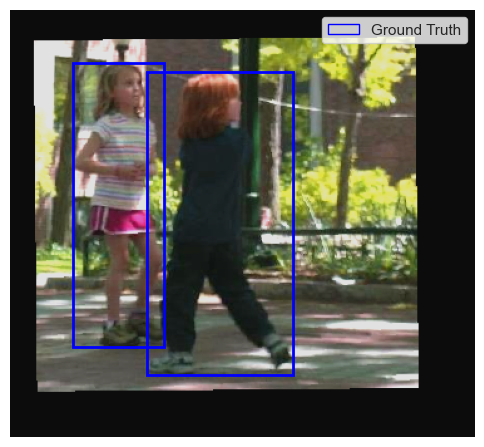

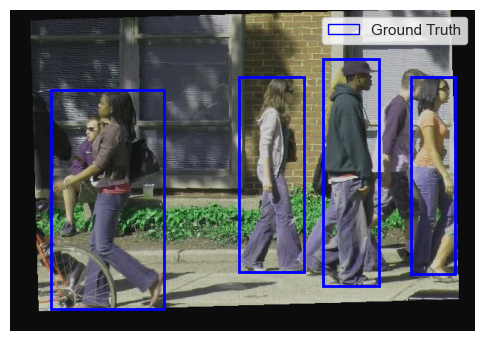

In [11]:
# Display random samples with ground truth and predictions with no filtering
selected_images = [22,5, 50]
display_images_and_boxes(train_dataset, indices=selected_images, denormalize=False)

In [9]:
# model configuration
checkpoint_file = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone_name = 'resnet50' 
weights = "DEFAULT"

backbone = resnet_fpn_backbone(backbone_name=backbone_name, weights=weights)
model = FasterRCNN(backbone, num_classes=2)

# Set up device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') # MPS doesn't work with Faster R-CNN
model.to(device)

# training configuration
initial_lr = 0.005  # Initial learning rate
weight_decay = 0.0005
patience_early = None  # disable early stopping
num_epochs = 30
patience_reduce = 3 # reduce the learning rate after 3 epochs without improvement

# Optimizer and scheduler
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=0.9, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=patience_reduce)

# Example usage
results = train_rcnn(model, optimizer, scheduler, train_loader, val_loader, device, 
                     checkpoint_file, num_epochs=num_epochs, patience=patience_early, pretend_train=False)

False C:\Users\bagge\My Drive\Python_Projects\DS776_Develop_Project\models\L06_fasterrcnn_resnet50_pennfudan.pth
Epoch [1/30], Train Loss: 0.4115, Val Loss: 0.3096, mAP@50: 0.4867, mAP@50-95: 0.2658, LR: 0.005000
Epoch [2/30], Train Loss: 0.2492, Val Loss: 0.2666, mAP@50: 0.5188, mAP@50-95: 0.2797, LR: 0.005000
Epoch [3/30], Train Loss: 0.2331, Val Loss: 0.2073, mAP@50: 0.8339, mAP@50-95: 0.4921, LR: 0.005000
Epoch [4/30], Train Loss: 0.2048, Val Loss: 0.2182, mAP@50: 0.9191, mAP@50-95: 0.5658, LR: 0.005000
Epoch [5/30], Train Loss: 0.1999, Val Loss: 0.1999, mAP@50: 0.9343, mAP@50-95: 0.5424, LR: 0.005000
Epoch [6/30], Train Loss: 0.1980, Val Loss: 0.1886, mAP@50: 0.9350, mAP@50-95: 0.7081, LR: 0.005000
Epoch [7/30], Train Loss: 0.1802, Val Loss: 0.1800, mAP@50: 0.9668, mAP@50-95: 0.7489, LR: 0.005000
Epoch [8/30], Train Loss: 0.1809, Val Loss: 0.1671, mAP@50: 0.9571, mAP@50-95: 0.7085, LR: 0.005000
Skipping index 116: min(): Expected reduction dim to be specified for input.numel() == 

Let's plot some convergence results:

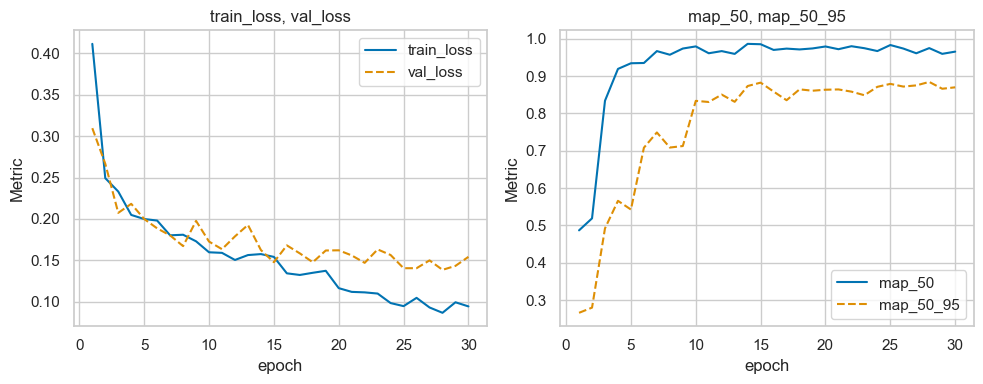

In [10]:
checkpoint_file = MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
results = load_results(checkpoint_file)

plot_training_metrics(results, [['train_loss', 'val_loss'], ['map_50', 'map_50_95']])

Now let's visualize some predictions on the validation set. We reinstantiate the model and load the saved weights in case we want to visualize without re-running the training.

In [20]:

checkpoint_file= MODELS_PATH / "L06_fasterrcnn_resnet50_pennfudan.pth"
backbone = resnet_fpn_backbone(backbone_name='resnet50', weights="DEFAULT")
model = FasterRCNN(backbone, num_classes=2)
model = load_model(model, checkpoint_file)
model.eval();

This short video looks at some of the predictions from our fine-tuned model.

INSERT VIDEO HERE.

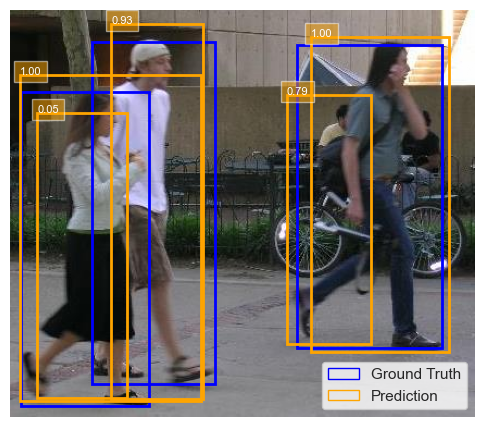

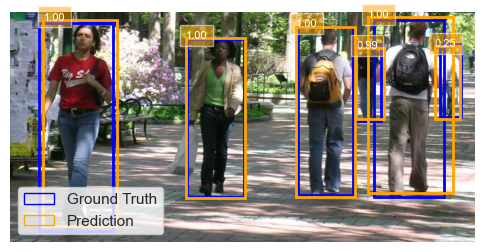

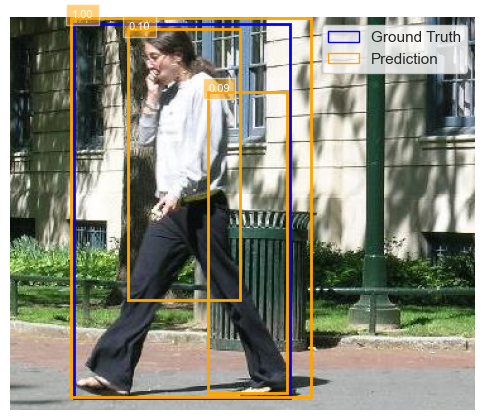

In [21]:
# Display random samples with ground truth and predictions with no filtering
selected_images = [0,4,6]
display_images_and_boxes(val_dataset, model=model, indices=selected_images,denormalize=False, 
                         min_confidence=0.0, iou_max_overlap=1.0, show_confidence=True)

### Performs Non-Maximum Suppression (NMS) and confidence filtering for object detection.

Non-Maximum Suppression (NMS):
NMS is a technique used to eliminate redundant or overlapping bounding boxes in object detection. 
It selects the bounding box with the highest confidence score and suppresses all other boxes that 
have a high overlap (Intersection over Union, IoU) with the selected box. This helps in reducing 
multiple detections of the same object.  Our Faster R-CNN model already uses NMS with an IoU threhsold of 0.5 so that redundant lower confidence boxes with at least 0.5 IoU overlap with the most confident box are eliminated.  You can suppress even more redundant boxes by lowering the threshold further.

Confidence Filtering:
Confidence filtering involves removing bounding boxes that have a confidence score below a certain 
threshold. This helps in eliminating low-confidence detections, thereby improving the precision 
of the object detection model.

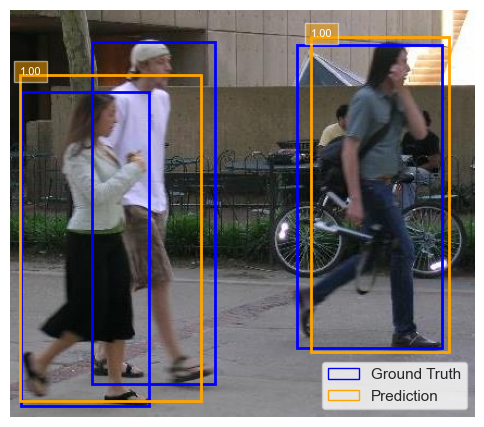

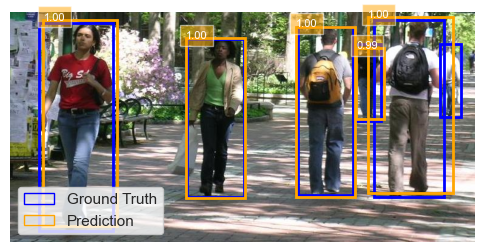

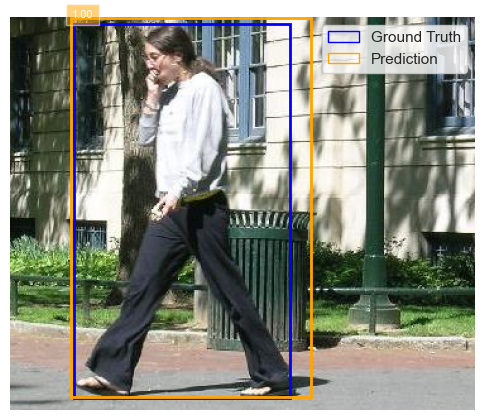

In [22]:
# Display random samples with ground truth and predictions with no filtering
display_images_and_boxes(val_dataset, model=model, indices=selected_images, min_confidence=.5, iou_max_overlap = 0.3, denormalize=False, show_confidence=True)